# Shifted window transformers

<script async defer src="https://buttons.github.io/buttons.js"></script>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-star" data-size="large" aria-label="Star stratisMarkou/random-walks on GitHub" style="float: right;">Star</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/issues" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-issue-opened" data-size="large" aria-label="Issue stratisMarkou/random-walks on GitHub">Issue</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/subscription" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-eye" data-size="large" aria-label="Watch stratisMarkou/random-walks on GitHub">Watch</a>
<a class="github-button" href="https://github.com/stratisMarkou" data-color-scheme="no-preference: light; light: light; dark: dark;" data-size="large" aria-label="Follow @stratisMarkou on GitHub">Follow</a>


[Transformers](../transformers/transformers.ipynb) are an extremely flexible deep learning architecture which has greatly impacted a range of machine learning applications.
Arguably, the impact of the transformer is due to its high modelling capacity, and its applicability to different data modalities with minimal changes to its implementation.
The distinguishing feature which gives the transformer these advantages is its attention layer.
Attention allows the transformer block to update the features of its input tokens in an adaptive way that depends on the features themselves, making the overall architecture extremely flexible.
Further, attention can be straightforwardly applied to data of various kinds, such as text, images, graphs and many more.
Arguably, due to these factors, transformers have been used across a range of applications with widespread success.

However, one important limitation of atention is that its computation and memory costs scale quadratically with the number of tokens in a sequence.
This makes standard transformers difficult to scale to inputs with many tokens such as, for example, long sentences or large images.
The shifted window transformer (Swin) is an architecture which helps address the computational and memory complexity issues of transformers by modifying the attention operation.
Swin was originally formulated to tackle image data, on which we focus here, but note that the main idea behind Swin is also applicable to other data modalities such as text or, more generally, any kind of gridded data.
The innovation of the Swin transformer is to apply attention in a local way, such that only tokens which are near each other (in some appropriate sense of closeness) affect each other in the attention operation.
In this sense Swin transformers are somewhat similar to convolutional neural networks (CNNs), where each input pixel affects only a local neighbourhood of output pixels at each layer of the network.
This reduces the computational cost of the Swin transformer from quadratic to linear in the number of input tokens allowing scaling to large numbers of tokens.

## Local self-attention
The main bottleneck in scaling transformers to large numbers of tokens is the self-attention operation.
Given $N$ tokens, simply building an $N \times N$ attention matrix requires $\mathcal{O}(N^2)$ compute and memory, which quickly gets very expensive for large images.
The idea behind the Swin transformer is to modify the self-attention operation, by breaking up an input image into smaller chunks, or windows, and having each token attend to all other tokens within its window, and to no other tokens outside it, as illustrated by the following image.

```{figure} ./vit_vs_swin.png
---
height: 150px
name: vit_vs_swin
---
Comparison of the self-attention operations in a standard vision transformer (left) and a Swin transformer (right).
Each gray square corresponds to a token.
The red boxes mark groups of tokens over which attention is applied.
```


Whereas in a standard vision transformer (left) each token (gray squares) attends to every other token in the image (large red square), in a Swin transformer each token attends only to those tokens within its window (smaller red squares), and none outside it.
This significantly reduces the size of the attention matrices that need to be calculated.
For example in the ViT in the illustration above, we have $64$ tokens, resulting in a $64 \times 64$ attention matrix which has $4096$ entries.
Breaking these up into four independent windows means each attention window contains $16$ tokens, resulting in four $16 \times 16$ attention matrices with $256$ entries, for a total of $1024$ entries across all four windows - a factor of $4$ lower.
These savings become much more significant for larger images.
So far so good.
However, this approach has a problem: tokens across different windows do not affect each other, which means that 

## Attention vs convolutions

:::{dropdown} An aside: reverse of patch extraction as transpose operation

__Invertibility.__
Under certain conditions patch extraction can be undone, leveraging the fact that the reverse operation is actually its transpose.
However, there are exaples of patch extraction which cannot be reversed.
For example, if we use large strides and small patch sizes, or if we use dilation (also known as à trous; this is the `rate` argument in `tf.image.extract_patches`), then some of the pixels of the input image may be skipped over, and not affect the output at all.
This means the patch extraction operation cannot be undone.
From now on, we will assume that the patch extraction is performed using a combination of patch size, striding and dilation such that every pixel in the input affects the output, and no pixels are skipped over.

__Matrix view.__
Suppose the input image $x$ is an array of shape $(H, W, C),$ where $H$ is its height, $W$ is its width and $C$ is the number of channels.
We can view patch extraction as a linear operation $P$ which maps the image $x$ to another image $y = P(x),$ of shape $(I, J, K),$ where the dimensions denote the horizontal patch index, vertical patch index and patch dimension respectively.
Note that by the definition of patch extraction, each pixel in the output is affected by exactly one pixel in the input (though each pixel in the input may affect more than one pixel in the output).
For now, let us assume that each pixel in the input affects exactly one pixel in the output, i.e. each $x_{hwc}$ affects exactly one $y_{ijk}.$
Let's define $\texttt{flat}$ to be the operation that takes a multi-dimensional array and flattens it into a single-dimensional array.
Since $\texttt{flat}$ is an invertible linear operation, and patch extraction is also an invertible linear operation, then their composition is also an invertible linear opeartion $P'.$
Let $\mathcal{M}(P')$ be the matrix corresponding to $P',$ so that

$$\texttt{flat}(y) = \mathcal{M}(P') \texttt{flat}(x).$$

Now note that since each element of $\texttt{flat}(x)$ affects precisely one element of $\texttt{flat}(y),$ the matrix $\mathcal{M}(P')$ is actually a permutation matrix, i.e. it contains exactly one $1$ in each row and in each column, and all other entries are $0.$
Now, the inverse of a permutation matrix is its transpose, that is

$$\texttt{flat}(x) = \mathcal{M}(P')^\top \texttt{flat}(y).$$

So the inverse of the patch embedding operation is actually its transpose operation, and that's because the patch embedding is actually a permutation!

__General case.__
But what happens in the more general case where some $x_{hwc}$ affect more than one $y_{ijk}$?
The equation $\texttt{flat}(y) = \mathcal{M}(P') \texttt{flat}(x)$ still holds, and the matrix $\mathcal{M}(P')$ stil contains a single $1$ per row.
However, $\mathcal{M}(P')$ may now contain multiple $1$ entries in each column.
Therefore, it is no longer a permutation matrix, and $\texttt{flat}(x) \neq \mathcal{M}(P')^\top \texttt{flat}(y).$
In particular, when we multiply $\texttt{flat}(y)$ by $\mathcal{M}(P')^\top,$ each entry of $\texttt{flat}(x)$ which affects $n$ entries in $\texttt{flat}(y)$ will be counted $n$ times.
To illustrate this problem, suppose consider the following vectors and matrices (which do not correspond to patch extraction, and are just an illustration of the problem) and the following matrix-vector multiplication

$$
u = \begin{bmatrix}
u_1 \\
u_2
\end{bmatrix}, M = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
0 & 1
\end{bmatrix} \implies v = Mu = \begin{bmatrix}
u_1 \\
u_2 \\
u_2
\end{bmatrix}.
$$

If we multiply $v = Mu$ by $M^\top$ we obtain

$$
M^\top v = M^\top Mu = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 1
\end{bmatrix} \begin{bmatrix}
u_1 \\
u_2 \\
u_2
\end{bmatrix} = \begin{bmatrix}
u_1 \\
2u_2
\end{bmatrix},
$$

i.e. we have double-counted $u_2.$
If instead we divide each row of $M^\top$ by its sum before multiplying we obtain

$$
M^\top v = \begin{bmatrix}
1 & 0 & 0\\
0 & \frac{1}{2} & \frac{1}{2}
\end{bmatrix} \begin{bmatrix}
u_1 \\
u_2 \\
u_2
\end{bmatrix} = \begin{bmatrix}
u_1 \\
u_2
\end{bmatrix},
$$

which is the desired result.
Therefore, all we have to do is divide each row of $M^\top$ by its sum, or alternatively divide each entry of $M^\top v$ by the sum of each row of $M^\top.$

__Implementation.__
We can perform all of the above in a few lines in Tensorflow, or a similar autodiff framework, as shown above.
First, the command

```
tf.gradients(y, x, grad_ys=y)[0]
```

computes the gradients of the scalar `sum(y)` with respect to `x` and multiplies these gradients together with the corresponding entries in `grad_ys`, as performed in revrse mode differentiation.
This is equivalent to the multiplication $\mathcal{M}(P')^\top \texttt{flat}(y)$ except the tensors are not actually flattened, but retain their original shapes.
Then, the command

```
tf.gradients(y, x)[0]
```

computes the derivative of `sum(y)` with respect to `x`.
If an entry in `x` affects $n$ entries in `y`, then the gradient of `sum(y)` with respect to that entry of `x` will be $n,$ so the division

```
tf.gradients(y, x, grad_ys=y)[0] / tf.gradients(y, x)[0]
```

gives the result we were after.
:::

Here is an illustration of the application of a shifted multi-head self-attention layer.

![](cyclic_shifts.png)

In [185]:
from typing import Optional, List

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfk = tf.keras

# Type for random seed
Seed = [tf.Tensor, tf.Tensor]

Most of the implementation for a Swin transformer is identical to that of a standard transformer, so we will reuse most of the code from the [introduction to transformers example](../transformers/transformers.ipynb).

In [186]:
class SelfAttention(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        projection_dim: int,
        name: str = "self_attention",
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        # Split the seed and set up the dense layers
        seed1, seed2 = tfp.random.split_seed(seed, 2)

        self.Uk = tfk.layers.Dense(
            projection_dim,
            activation="gelu",
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed1[0])),
        )

        self.Uq = tfk.layers.Dense(
            projection_dim,
            activation="gelu",
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed2[0])),
        )


    def self_attention_weights(self, x: tf.Tensor) -> tf.Tensor:
        """
        Compute self-attention weights for tokens in a sequence

        Args:
            x: input sequence of tokens, shape (B, N, D)
        
        Returns:
            attention weights, shape (B, N, N)
        """
        k = self.Uk(x)
        q = self.Uq(x)

        dot_product = tf.matmul(k, q, transpose_b=True)
        dot_product /= tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))

        return tf.nn.softmax(dot_product, axis=1)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply self-attention to a sequence of tokens

        Args:
            x: input sequence of tokens, shape (B, N, D)

        Returns:
            output sequence of tokens, shape (B, N, D)
        """
        return tf.matmul(self.self_attention_weights(x), x, transpose_a=True)


class MultiHeadSelfAttention(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dim: int,
        projection_dim: int,
        num_heads: int,
        name: str = "multi_head_self_attention",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        keys = tfp.random.split_seed(seed, 2*num_heads)
        self.self_attention = [
            SelfAttention(
                seed=key,
                projection_dim=projection_dim,
            ) for key in keys[::2]
        ]

        self.linear = [
            tfk.layers.Dense(
                token_dim,
                use_bias=False,
                activation=None,
                kernel_initializer=tf.initializers.GlorotNormal(seed=int(key[0])),
            ) for key in keys[1::2]
        ]

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply multi-head self-attention to a sequence of tokens

        Args:
            x: input sequence of tokens, shape (B, N, D)

        Returns:
            output sequence of tokens, shape (B, N, D)
        """
            
        # Compute tokens for each head and apply linear 
        heads = [
            linear(sa(x))
            for sa, linear in zip(self.self_attention, self.linear)
        ]

        # Stack and sum across heads
        return tf.reduce_mean(tf.stack(heads, axis=2), axis=2)


class MLP(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        num_hidden: int,
        num_layers: int,
        num_output: Optional[int] = None,
        name: str = "mlp",
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        # Set up output dimensions of linear layers
        out_feats = [num_hidden] * num_layers + [num_output]

        # Split the random key into sub-keys for each layer
        seeds = tfp.random.split_seed(seed, num_layers+1)

        self.linear = [
            tfk.layers.Dense(
                out_feat,
                activation=None,
                kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
            )
            for seed, out_feat in zip(seeds, out_feats)
        ]


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Compute forward pass through the MLP.

        Args:
            x: input tensor of shape (..., feature_dim,)
        
        Returns:
            output tensor of shape (..., feature_dim,)
        """
        for layer in self.linear[:-1]:
            x = layer(x)
            x = tf.nn.gelu(x)
        return self.linear[-1](x)


class TransformerBlock(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        name: str = "swin_transformer_block",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        key1, key2 = tfp.random.split_seed(seed, 2)
        self.mhsa = MultiHeadSelfAttention(
            seed=key1,
            token_dim=token_dimension,
            projection_dim=token_dimension,
            num_heads=num_heads,
        )

        self.mlp = MLP(
            seed=key2,
            num_hidden=mlp_num_hidden,
            num_layers=mlp_num_layers,
            num_output=token_dimension,
        )

        self.ln1 = tfk.layers.LayerNormalization(axis=2)
        self.ln2 = tfk.layers.LayerNormalization(axis=2)

    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply the transformer block to input tokens `x`.

        Arguments:
            x: input tensor of shape (B, N, D)

        Returns:
            output tensor of shape (B, N, D)
        """
        x = x + self.mhsa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))

        return x
    

class ImageTokeniser(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        patch_size: int,
        name: str = "image_tokeniser",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        assert patch_size == 1 or patch_size % 2 == 0, "Patch size must be one or even"

        self.conv = tfk.layers.Conv2D(
            filters=token_dimension,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            activation=None,
            data_format="channels_last",
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Tokenise the image `x`, applying a strided convolution.
        This is equivalent to splitting the image into patches,
        and then linearly projecting each one of these using a
        shared linear projection.

        Arguments:
            x: image input tensor of shape (B, W, H, C)

        Returns:
            output tensor of shape (B, N, D)
        """

        assert (
            x.shape[1] % self.conv.kernel_size[0] == 0
            and x.shape[2] % self.conv.kernel_size[1] == 0
        ), (
            f"Input dimensions must be divisible by patch size, "
            f"found {x.shape=} and {self.conv.kernel_size}."
        )

        return self.conv(x)
    

class PositionEmbedding(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        height: int,
        width: int,
        name: str = "position_embedding",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        
        self.embeddings = tf.Variable(
            tf.random.normal(
                (height, width, token_dimension),
                seed=int(seed[0]),
            )
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Add position embeddings to input tensor.

        Arguments:
            x: input tensor of shape (B, H, W, D)

        Returns:
            output tensor of shape (B, H, W, D)
        """
        return x + self.embeddings[None, :, :, :]

In [187]:
def shift_horizontally_and_vertically(x: tf.Tensor, shift: int) -> tf.Tensor:
    """
    Shift windows in the input tensor `x` by shift along its width and height.
    For example, using shift == 1 (and neglecting the B and D dimensions),
    the H and W dimensions would change as follows:
    
                      Original                Shifted
                 -----------------       -----------------
                |  x   x   x   o  |     |  *   +   +   +  |
                |  x   x   x   o  |     |  o   x   x   x  |
                |  x   x   x   o  |     |  o   x   x   x  |
                |  +   +   +   *  |     |  o   x   x   x  |
                 -----------------       -----------------
    
    Arguments:
        x: input tensor of shape (B, H, W, D)
        shift: amount of shift to apply

    Returns:
        output tensor of shape (B, H, W, D)
    """
    return tf.roll(tf.roll(x, shift, axis=1), shift, axis=2)


def extract_windows(x: tf.Tensor) -> tf.Tensor:
    """
    Extract non-overlapping windows from input tensor `x`.

    Arguments:
        x: input tensor of shape

    Returns:
        output tensor of shape (B*(H//2)*(W//2), 4, D)
    """
    B = tf.shape(x)[0]
    H = tf.shape(x)[1]
    W = tf.shape(x)[2]
    D = tf.shape(x)[3]

    x = tf.reshape(x, [B, H//2, 2, W//2, 2, D])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])  # (B, H//2, W//2, 2, 2, D)
    x = tf.reshape(x, [B*H//2*W//2, 4, D])
    return (B, H, W, D), x


def combine_windows(x: tf.Tensor, original_shape: tf.Tensor) -> tf.Tensor:
    """
    Combine windows extracted from input tensor `x`.

    Arguments:
        x: input tensor of shape (B*(H//2)*(W//2), 4, D)
        x_shape: shape of original tensor

    Returns:
        output tensor of shape (B, H, W, D)
    """
    B, H, W, D = original_shape
    x = tf.reshape(x, [B, H//2, W//2, 2, 2, D])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])  # (B, H//2, 2, W//2, 2, D)
    x = tf.reshape(x, [B, H, W, D])
    return x

In [206]:
class PatchMergingLayer(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        num_out_features: int,
        name: str = "patch_merging",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        self.linear = tfk.layers.Dense(
            num_out_features,
            activation=None,
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
        )

        self.num_out_features = num_out_features
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply patch merging to input tensor `x`.

        Arguments:
            x: input tensor of shape (B, H, W, D)

        Returns:
            output tensor of shape (B, H//2, W//2, 2*D)
        """
        x = tf.image.extract_patches(
            x,
            sizes=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )  # (B, H//2, W//2, 4*D)
        return self.linear(x)  # (B, H//2, W//2, 2*D)

In [216]:
class SwinTransformerBlockStage(tfk.Model):
    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        num_block_pairs: int,
        name: str = "swin_transformer_block", 
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        seeds = tfp.random.split_seed(seed, 2*num_block_pairs)
        self.first_blocks = [
            TransformerBlock(
                seed=seeds[2*i],
                token_dimension=token_dimension,
                mlp_num_hidden=mlp_num_hidden,
                mlp_num_layers=mlp_num_layers,
                num_heads=num_heads,
            )
            for i in range(num_block_pairs)
        ]

        self.second_blocks = [
            TransformerBlock(
                seed=seeds[2*i+1],
                token_dimension=token_dimension,
                mlp_num_hidden=mlp_num_hidden,
                mlp_num_layers=mlp_num_layers,
                num_heads=num_heads,
            )
            for i in range(num_block_pairs)
        ]


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply the Swin Transformer block to input tokens `x`.

        Arguments:
            x: input tensor of shape (B, H, W, D)

        Returns:
            output tensor of shape (B, H, W, D)
        """

        for first_block, second_block in zip(self.first_blocks, self.second_blocks):

            original_shape, x = extract_windows(x)  # (B*H//2*W//2, 4, D)
            x = first_block(x)  # (B*H//2*W//2, 4, D)
            x = combine_windows(x, original_shape)  # (B, H, W, D)
            x = shift_horizontally_and_vertically(x, 1)  # (B, H, W, D)

            original_shape, x = extract_windows(x)  # (B*H//2*W//2, 4, D)
            x = second_block(x)  # (B*H//2*W//2, 4, D)
            x = combine_windows(x, original_shape)  # (B, H, W, D)
            x = shift_horizontally_and_vertically(x, -1)  # (B, H, W, D)

        x = combine_windows(x, original_shape)  # (B, H, W, D)

        return x

In [217]:
class TinySwinTransformer(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        tokeniser: ImageTokeniser,
        embedding: PositionEmbedding,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        num_classes: int,
        num_blocks_per_stage: List[int],
        name: str = "tiny_swin_transformer",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        num_stages = len(num_blocks_per_stage)
        seeds = tfp.random.split_seed(seed, 2*num_stages+1)

        self.stages = []
        self.patch_merging_layers = []

        for i, n in enumerate(num_blocks_per_stage):
            self.patch_merging_layers.append(
                PatchMergingLayer(
                    seed=seeds[2*i+1],
                    num_out_features=(2**i)*token_dimension,
                )
            )
            self.stages.append(
                SwinTransformerBlockStage(
                    seed=seeds[2*i],
                    token_dimension=(2**i)*token_dimension,
                    mlp_num_hidden=mlp_num_hidden,
                    mlp_num_layers=mlp_num_layers,
                    num_heads=num_heads,
                    num_block_pairs=n,
                )
            )

        self.final_mlp = MLP(
            seed=seeds[-1],
            num_hidden=mlp_num_hidden,
            num_layers=mlp_num_layers,
            num_output=num_classes,
        )

        self.tokeniser = tokeniser
        self.embedding = embedding

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply vision transformer to batch of images.

        Arguments:
            x: input image tensor of shape (B, H, W, C)

        Returns:
            output logits tensor of shape (B, num_classes)
        """

        x = self.tokeniser(x)
        x = self.embedding(x)

        for patch_merging, stage in zip(self.patch_merging_layers, self.stages):
            x = patch_merging(x)
            x = stage(x)

        x = tf.reshape(x, [tf.shape(x)[0], -1, tf.shape(x)[-1]])
        x = self.final_mlp(tf.reduce_mean(x, axis=1))
        return x - tf.math.reduce_logsumexp(x, axis=1, keepdims=True)

### Dataset
Because this is meant to be a demo that should run on a laptop, we'll use the MNIST dataset.
We'll use [tensorflow datasets](https://www.tensorflow.org/datasets/api_docs/python/tfds) to load the data and preprocess it.

In [218]:
import tensorflow as tf
import tensorflow_datasets as tfds

def preprocess_image(image, label):
    image = 2. * (tf.cast(image, tf.float32) / 255.) - 1.
    image = tf.image.resize(image, [32, 32])
    return image, label

def get_batches(batch_size: int, split: str, data_dir: str="/tmp/tfds"):

    # Conversion from labels to one-hot
    def one_hot(image, label):
        return image, tf.one_hot(label, 10)

    assert split in ["train", "test"], "Split must be 'train' or 'test'"
    ds = tfds.load(
        name="mnist",
        split=split,
        as_supervised=True,
        data_dir=data_dir,
        shuffle_files=False,
    )
    ds = ds.map(preprocess_image)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.map(one_hot)

    return ds

### Training
Now let's train the network.
In general, when training a ViT, a few tricks are typically used, including for example, learning rate scheduling and data augmentation.
Dropout is also sometimes used in the architecture itself.
We won't use any of these techniques here to keep it simple.

In [250]:
@tf.function
def train_step(
    model: tfk.Model,
    images: tf.Tensor,
    labels: tf.Tensor,
    loss_fn: tf.losses.Loss,
    optimizer: tf.optimizers.Optimizer,
) -> tf.Tensor:
    
    with tf.GradientTape() as tape:
        logits = model(images)
        loss = loss_fn(labels, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, logits

# Model parameters
token_dimension = 64
patch_size = 1
num_mlp_hidden = 64
num_mlp_layers = 1
num_heads = 8
num_classes = 10
num_blocks_per_stage = [1, 1, 1, 1]

# Training parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-6

# Create the tokeniser and embeddings
seeds = tfp.random.split_seed([0, 0], 3)

tokeniser = ImageTokeniser(
    seeds[0],
    token_dimension=token_dimension,
    patch_size=patch_size,
)

embedding = PositionEmbedding(
    seeds[1],
    token_dimension=token_dimension,
    height=32,
    width=32,
)

# Create a transformer
transformer = TinySwinTransformer(
    seeds[2],
    tokeniser=tokeniser,
    embedding=embedding,
    token_dimension=token_dimension,
    mlp_num_hidden=num_mlp_hidden,
    mlp_num_layers=num_mlp_layers,
    num_heads=num_heads,
    num_classes=num_classes,
    num_blocks_per_stage=num_blocks_per_stage,
)

# Create optimizer
optimizer = tf.optimizers.Adam(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)

# Create loss function and accuracy helpers
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
accuracy = tf.metrics.CategoricalAccuracy()

In [251]:
from tqdm.notebook import tqdm

# Keep track of losses and accuracies for plotting
all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []
num_steps = 0

for epoch in range(num_epochs):

    pbar = tqdm(get_batches(batch_size, "train"))

    epoch_losses = []
    epoch_accuracies = []
    for images, labels in pbar:
        loss, logits = train_step(
            transformer,
            images,
            labels,
            loss_fn,
            optimizer,
        )
        acc = accuracy(labels, logits)

        epoch_losses.append(loss)
        epoch_accuracies.append(acc)
        all_train_losses.append((num_steps, loss))
        all_train_accuracies.append((num_steps, acc))

        num_steps += 1

        pbar.set_description(
            f"Epoch ({epoch+1:03d}) "
            f"mean loss: {tf.reduce_mean(epoch_losses):.3f}, "
            f"mean accuracy: {tf.reduce_mean(epoch_accuracies):.3f}"
        )

    test_losses = []
    test_accuracies = []
    for images, labels in get_batches(batch_size, "test"):

        logits = transformer(images)
        test_losses.append(loss_fn(labels, logits))
        test_accuracies.append(accuracy(labels, logits))

    mean_loss = tf.reduce_mean(test_losses)
    mean_acc = tf.reduce_mean(test_accuracies)
    all_test_losses.append((num_steps, mean_loss))
    all_test_accuracies.append((num_steps, mean_acc))

print(
    f"Epoch {num_epochs}: "
    f"loss {mean_loss:.3f} (train {tf.reduce_mean(epoch_losses):.3f}), "
    f"acc. {mean_acc:.3f} (train {tf.reduce_mean(epoch_accuracies):.3f})"
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 10: loss 0.089 (train 0.024), acc. 0.973 (train 0.972)


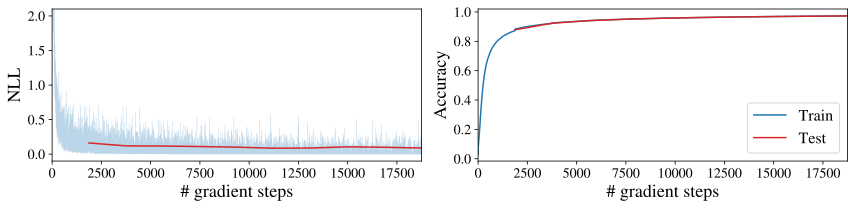

In [253]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

train_steps, train_nlls = zip(*all_train_losses)
_, train_accs = zip(*all_train_accuracies)
test_steps, test_nlls = zip(*all_test_losses)
_, test_accs = zip(*all_test_accuracies)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_nlls, color="tab:blue",linewidth=0.5, alpha=0.3)
plt.plot(test_steps, test_nlls, color="tab:red")
plt.ylim([-0.1, 2.1])
plt.xlim([0, train_steps[-1]])
plt.xlabel("# gradient steps", fontsize=18)
plt.ylabel("NLL", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_steps, train_accs, color="tab:blue", label="Train")
plt.plot(test_steps, test_accs, color="tab:red", label="Test")
plt.xlim([0, train_steps[-1]])
plt.xlabel("# gradient steps", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

## Conclusion
We have looked at the details of the transformer architecture.
It consists of identical blocks, each of which contains a self-attention and a multi-layer perceptron operation, together with normalisation layers and residual connections.
Coupling these together with position embeddings and an appropriate tokenisation layer makes up the entire transformer architecture.
We looked at a specific example for computer vision, the ViT, and trained it on MNIST.

## References

```{bibliography}
:filter: docname in docnames
```